# Setup
If there are any issues with torchaudio, do a manual install for soundfile

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import random
import torchaudio
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from google.colab import files

In [ ]:
pip -q install torchaudio librosa soundfile numpy matplotlib IPython #if needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


## Download Data
We are utilizing the 'train-clean-100' dataset from LibriSpeech, which contains 100 hours of transcripted utterances. However, we will need to construct our own dataset from this by mixing waveforms together, which is done later.

In [2]:
# ~10 minutes
os.makedirs("./data", exist_ok=True)
dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(42)

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

100%|██████████| 5.95G/5.95G [05:14<00:00, 20.3MB/s]


## Extract clean data
This method will extract the indices of datapoints that are greater than a given duration and do not clip (max_peak <= 0.95). It will then be stored in a file ```meta/clean_metadata.json``` for reuse.

In [3]:
def clean_data(min_duration=1.5, max_peak=0.95, sr=16000, save_dir="spectrogram_data"):
    dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=False)

    cleaned = []

    if os.path.exists('meta/clean_metadata.json'):
        with open('meta/clean_metadata.json', 'r') as f:
            return json.load(f)

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs("meta", exist_ok=True)


    for i in range(len(dataset)):
        waveform, sample_rate, _, speaker_id, _, utt_id = dataset[i]

        duration = waveform.shape[1] / sample_rate
        peak_val = waveform.abs().max().item()

        if duration >= min_duration and peak_val <= max_peak:
            waveform = waveform.mean(dim=0, keepdim=True)

            cleaned.append({
                "index": i,
                "duration": duration,
                "speaker_id": int(speaker_id),
                "utterance_id": int(utt_id)
            })


    with open("meta/clean_metadata.json", "w") as f:
        json.dump(cleaned, f, indent=2)

    return cleaned


## Data Creation
Constructing data by mixing waves and separating dataset into a train and test by unique speakers to avoid leakage.


In [4]:
# Returns a list of speakers from the clean_data json
def group_by_speaker(metadata):
    speakers = []
    for entry in metadata:
        if speakers[entry[['speaker_id']]] is None:
            speakers[entry["speaker_id"]] = [entry]
        else:
            speakers[entry["speaker_id"]].append(entry)
    return speakers

# Randomly divide speakers into the test and train sets
def split_speakers(metadata, test_frac=0.1):
    speakers = list(set(entry["speaker_id"] for entry in metadata))
    random.shuffle(speakers)

    split_point = int(len(speakers) * (1 - test_frac))
    train_speakers = set(speakers[:split_point])
    test_speakers  = set(speakers[split_point:])

    train_meta = [m for m in metadata if m["speaker_id"] in train_speakers]
    test_meta  = [m for m in metadata if m["speaker_id"] in test_speakers]

    return train_meta, test_meta

# Transforms a STFT spectrogram with complex values into one with only real values
# [B, T, F, 2] -> [B, T, F*2],
# B = batch size, T = time points, F = frequency bins
def transform_data(data_point):
    data_point = torch.view_as_real(data_point).permute(0,2,1,3)
    B, T, F, _ = data_point.shape
    data_point = data_point.reshape(B, T, F*2)
    return data_point

In [ ]:
# Dataset to mix waves
# Lazy Loading Dataset to reduce memory consumption
class SpectrogramDataset(Dataset):
    def __init__(self, metadata, dataset, data_points=5000, duration=5.0, n_fft=1024, hop_length=256):
        self.metadata = metadata
        self.dataset = dataset
        self.sr = 16000
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_len = int(duration * self.sr)
        self.data_points=data_points

    # Pad wave to ensure they are all the same length
    def pad(self, wave):
        pad_amt = self.max_len - wave.shape[1]
        if pad_amt > 0:
            wave = torch.nn.functional.pad(wave, (0, pad_amt))
        return wave[:, :self.max_len]

    # Defines how many data points it will train over
    def __len__(self):
        return min(len(self.metadata), self.data_points)

    # Finds two waves with distinct speakers and mixes
    # Wave 1 is default target
    def __getitem__(self, _):
        while True:
            s1, s2 = random.sample(range(len(self.metadata)), 2)
            meta1, meta2 = self.metadata[s1], self.metadata[s2]
            if meta1["speaker_id"] != meta2["speaker_id"]:
                break

        wave1, _, *_ = self.dataset[meta1["index"]]
        wave2, _, *_ = self.dataset[meta2["index"]]
        wave1 = self.pad(wave1)
        wave2 = self.pad(wave2)

        mix = 0.8 * wave1 + 0.2 * wave2

        # Compute Spectrogram from waveform using STFT, retain complex terms (phase)
        mix_spec = torch.stft(mix, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        target_spec = torch.stft(wave1, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)

        mix_spec = transform_data(mix_spec).squeeze()
        target_spec = transform_data(target_spec).squeeze()

        return mix_spec, target_spec

In [5]:
class SplitterRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super(SplitterRNN, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout)
    self.linear = nn.Linear(hidden_size, input_size)

  def forward(self, x, hidden):
    out, (h, c) = self.lstm(x, hidden)
    return self.linear(out), (h,c)

In [6]:
clean_data()
with open("meta/clean_metadata.json") as f:
    metadata = json.load(f)
train_meta, test_meta = split_speakers(metadata)

## Train and Test using Magnitude and Phase
Loss Function - MSE Loss over magnitude and phase

Batched, with sequence length and hidden/cell states carried over between sequences.

In [ ]:
# Parameters
input_size = 1026 # 513 * 2 (one for Real coeff, one for Imaginary coeff)
hidden_size = 512
num_layers = 2
batch_size = 16
sequence_length = 150
dropout = 0.25
lr = 0.001
sample_rate=16000 # SR defined by LibriSpeech

hop_length=256
n_fft = 1024

In [ ]:
def train_rnn(model, criterion, optimizer, train_loader, num_layers=2, batch_size=8, hidden_size=512, seq_len=100, nepochs=5000):
    losses = []
    model.train()

    for e in range(nepochs):
        total_loss = 0.0
        for mixes_batch, tgt_batch in train_loader:
            batch_size = mixes_batch.size(0)
            h0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            c0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            mixes_batch = mixes_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # [B, seq_len, F*2]
            for start in range(0, mixes_batch.shape[1], seq_len):
                mixes_subset = mixes_batch[:,start:start+seq_len,:]
                tgt_subset = tgt_batch[:,start:start+seq_len,:]
                # [B, seq_len, F*2]

                optimizer.zero_grad()
                output, (h0, c0) = model(mixes_subset, (h0, c0))
                # output: [B, seq_len, F*2]

                h0 = h0.detach()
                c0 = c0.detach()

                loss = criterion(output, tgt_subset)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        print(f"Epoch {e:2d} | Loss: {avg_loss:.6f}")

    return losses


In [ ]:
train_dataset = SpectrogramDataset(train_meta, dataset)
test_dataset  = SpectrogramDataset(test_meta, dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

model = SplitterRNN(input_size, hidden_size, num_layers, dropout).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

losses = train_rnn(model,
                   criterion,
                   optimizer,
                   train_loader,
                   num_layers=num_layers,
                   batch_size=batch_size,
                   hidden_size=hidden_size,
                   seq_len=sequence_length,
                   nepochs=5)

Epoch  0 | Loss: 2.551042
Epoch  1 | Loss: 1.954223
Epoch  2 | Loss: 1.753070
Epoch  3 | Loss: 1.658705
Epoch  4 | Loss: 1.577661


Text(0.5, 0, 'Epoch')

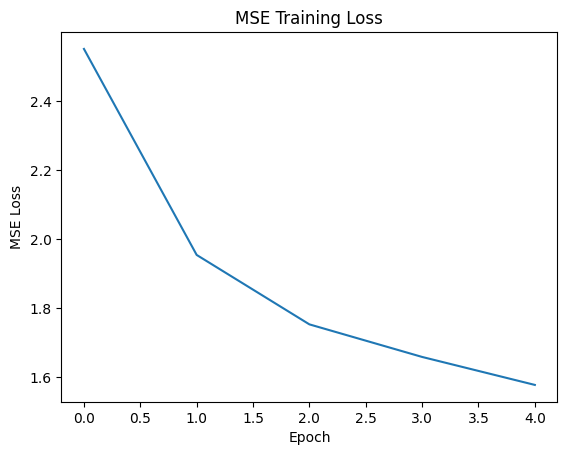

In [ ]:
plt.plot(losses)
plt.title("MSE Training Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")

In [ ]:
def test_rnn(model, criterion, test_loader, num_layers=2, batch_size=8, hidden_size=512, seq_len=100):
    model.eval()
    total_loss = 0.0

    # Takes random inp/out pair from each batch for later analysis
    inputs = []
    outputs = []
    with torch.no_grad():
        for mixes_batch, tgt_batch in test_loader:
            batch_size = mixes_batch.size(0)
            h0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            c0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            rand_idx = random.randint(0, batch_size-1)
            inputs.append(mixes_batch[rand_idx])
            mixes_batch = mixes_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            pred = []
            for start in range(0, mixes_batch.shape[1], seq_len):
                mixes_subset = mixes_batch[:,start:start+seq_len,:]
                tgt_subset = tgt_batch[:,start:start+seq_len,:]

                output, (h0, c0) = model(mixes_subset, (h0, c0))

                h0 = h0.detach()
                c0 = c0.detach()

                pred.append(output[rand_idx])
                loss = criterion(output, tgt_subset)
                total_loss += loss.item()
            outputs.append(pred)

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")
    return avg_loss, inputs, outputs

In [ ]:
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loss, inputs, outputs = test_rnn(model,
                                      criterion,
                                      test_loader,
                                      num_layers=num_layers,
                                      batch_size=batch_size,
                                      hidden_size=hidden_size,
                                      seq_len=sequence_length)
test_loss

Test Loss: 1.436083


1.4360828983433107

In [ ]:
# Inverse Transform from flattened Real/imaginary terms back to original
# [T, 2F] -> [T, F, 2]
# T = time points, F = frequency bins
def inverse_transform(data_point):
    T, F = data_point.shape
    data_point = data_point.view(T, F // 2, 2)
    data_point = torch.view_as_complex(data_point).transpose(0,1)
    return data_point

output_cat = [torch.cat(tensor_list) for tensor_list in outputs]

for i, (inp, out) in enumerate(zip(inputs, output_cat)):
    complex_inp, complex_out = inverse_transform(inp), inverse_transform(out)
    inp_waveform = torch.istft(complex_inp, n_fft=n_fft, hop_length=hop_length)
    out_waveform = torch.istft(complex_out, n_fft=n_fft, hop_length=hop_length)
    display(Audio(inp_waveform.cpu().numpy(), rate=sample_rate))
    display(Audio(out_waveform.cpu().numpy(), rate=sample_rate))
    if i == 5:
        break

torch.Size([513, 313])
torch.Size([513, 313])


<ipython-input-21-0eed27dfccec>:13: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:1023.)
  inp_waveform = torch.istft(complex_inp, n_fft=n_fft, hop_length=hop_length)


torch.Size([513, 313])
torch.Size([513, 313])


torch.Size([513, 313])
torch.Size([513, 313])


torch.Size([513, 313])
torch.Size([513, 313])


torch.Size([513, 313])
torch.Size([513, 313])


torch.Size([513, 313])
torch.Size([513, 313])


## Train with Magnitude only (no Phase)
Other changes:
Normalizing waveform prior to mixing, utilize a log_transform

In [7]:
# Parameters
input_size = 513
hidden_size = 512
num_layers = 2
batch_size = 16
sequence_length = 150
dropout = 0.25
lr = 0.001
sample_rate=16000

hop_length=256
n_fft = 1024

In [8]:
# Code written in conjunction with ChatGPT
def transform_data_mag(spec_complex):
    # Convert complex to log-magnitude
    mag = spec_complex.abs()  # shape: [B, F, T]
    log_mag = torch.log1p(mag)
    log_mag = log_mag.transpose(1, 2)  # [B, T, F]
    return log_mag

def normalize_waveform(wave):
    rms = torch.sqrt(torch.mean(wave ** 2)) + 1e-9
    return wave / rms

In [9]:
class MagSpectrogramDataset(Dataset):
    def __init__(self, metadata, dataset, data_points=10000, duration=5.0, n_fft=1024, hop_length=256):
        self.metadata = metadata
        self.dataset = dataset
        self.sr = 16000
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_len = int(duration * self.sr)
        self.data_points=data_points


    def pad(self, wave):
        pad_amt = self.max_len - wave.shape[1]
        if pad_amt > 0:
            wave = torch.nn.functional.pad(wave, (0, pad_amt))
        return wave[:, :self.max_len]

    def __len__(self):
        return min(len(self.metadata), self.data_points)

    def __getitem__(self, _):
        while True:
            s1, s2 = random.sample(range(len(self.metadata)), 2)
            meta1, meta2 = self.metadata[s1], self.metadata[s2]
            if meta1["speaker_id"] != meta2["speaker_id"]:
                break

        wave1, _, *_ = self.dataset[meta1["index"]]
        wave2, _, *_ = self.dataset[meta2["index"]]
        wave1 = normalize_waveform(self.pad(wave1))
        wave2 = normalize_waveform(self.pad(wave2))

        r = random.uniform(0.6, 0.8)
        # r = 0.8
        mix = r * wave1 + (1 - r) * wave2


        window = torch.hann_window(self.n_fft, device=mix.device)
        mix_spec = torch.stft(mix, n_fft=self.n_fft, hop_length=self.hop_length, window=window, return_complex=True)
        target_spec = torch.stft(wave1, n_fft=self.n_fft, hop_length=self.hop_length, window=window, return_complex=True)


        mix_mag = transform_data_mag(mix_spec).squeeze()
        target_mag = transform_data_mag(target_spec).squeeze()

        assert not torch.allclose(mix_mag, target_mag), "Mix and target are identical!"
        return mix_mag, target_mag, mix_spec.squeeze()


In [10]:
def train_rnn_mag(model, criterion, optimizer, train_loader, num_layers=2, batch_size=8, hidden_size=512, seq_len=100, nepochs=5):
    losses = []
    model.train()

    for e in range(nepochs):
        total_loss = 0.0
        for mix_logmag, target_logmag, _ in train_loader:
            batch_size = mix_logmag.size(0)
            h0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            c0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            mix_logmag = mix_logmag.to(device)
            target_logmag = target_logmag.to(device)

            for start in range(0, mix_logmag.shape[1], seq_len):
                x = mix_logmag[:, start:start+seq_len, :]
                y = target_logmag[:, start:start+seq_len, :]

                optimizer.zero_grad()
                out, (h0, c0) = model(x, (h0, c0))
                h0, c0 = h0.detach(), c0.detach()

                loss = criterion(out, y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {e:02d} | Loss: {avg_loss:.6f}")

    return losses

In [14]:
def test_rnn_mag(model, criterion, test_loader, num_layers=2, batch_size=8, hidden_size=512, seq_len=100):
    model.eval()
    total_loss = 0.0
    inputs = []
    outputs = []
    mix_phases = []

    with torch.no_grad():
        for mix_logmag, target_logmag, mix_complex in test_loader:
            batch_size = mix_logmag.size(0)
            h0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            c0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            rand_idx = random.randint(0, batch_size-1)
            inputs.append(mix_logmag[rand_idx])
            mix_logmag = mix_logmag.to(device)
            target_logmag = target_logmag.to(device)
            mix_complex = mix_complex.to(device)

            preds = []
            for start in range(0, mix_logmag.shape[1], seq_len):
                x = mix_logmag[:, start:start+seq_len, :]
                y = target_logmag[:, start:start+seq_len, :]

                out, (h0, c0) = model(x, (h0, c0))
                h0, c0 = h0.detach(), c0.detach()
                preds.append(out[rand_idx])
                loss = criterion(out, y)
                total_loss += loss.item()

            outputs.append(preds)
            mix_phases.append(mix_complex[rand_idx])

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")
    return avg_loss, inputs, outputs, mix_phases


In [12]:
train_dataset = MagSpectrogramDataset(train_meta, dataset, data_points=10000)
test_dataset  = MagSpectrogramDataset(test_meta, dataset, data_points=5000)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

mag_model = SplitterRNN(input_size, hidden_size, num_layers, dropout).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=mag_model.parameters(), lr=lr)

losses = train_rnn_mag(mag_model,
                   criterion,
                   optimizer,
                   train_loader,
                   num_layers=num_layers,
                   batch_size=batch_size,
                   hidden_size=hidden_size,
                   seq_len=sequence_length,
                   nepochs=10)

Epoch 00 | Loss: 1.070335
Epoch 01 | Loss: 0.875543
Epoch 02 | Loss: 0.817866
Epoch 03 | Loss: 0.780470
Epoch 04 | Loss: 0.755432
Epoch 05 | Loss: 0.738039
Epoch 06 | Loss: 0.722777
Epoch 07 | Loss: 0.723271
Epoch 08 | Loss: 0.705964
Epoch 09 | Loss: 0.699676


In [18]:
from google.colab import files
checkpoint_path = os.path.join(save_dir, "splitter_rnn_mag.pth")

torch.save({
    'model_state_dict': mag_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'n_fft': n_fft,
    'hop_length': hop_length
}, checkpoint_path)

print(f"Model saved to {checkpoint_path}")
files.download(checkpoint_path)

Model saved to checkpoints/splitter_rnn_mag.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
checkpoint = torch.load("checkpoints/splitter_rnn_mag.pth", map_location=device)

mag_model = SplitterRNN(
    input_size=checkpoint['input_size'],
    hidden_size=checkpoint['hidden_size'],
    num_layers=checkpoint['num_layers'],
    dropout=checkpoint['dropout']
).to(device)

mag_model.load_state_dict(checkpoint['model_state_dict'])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=mag_model.parameters(), lr=lr)
mag_model.eval()

SplitterRNN(
  (lstm): LSTM(513, 512, num_layers=2, batch_first=True, dropout=0.25)
  (linear): Linear(in_features=512, out_features=513, bias=True)
)

In [15]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

test_loss, inputs, outputs, mix_phases = test_rnn_mag(
    model=mag_model,
    criterion=criterion,
    test_loader=test_loader,
    num_layers=num_layers,
    batch_size=batch_size,
    hidden_size=hidden_size,
    seq_len=sequence_length
)

Test Loss: 0.785878


----

In [16]:
def decompress(log_mag):
    return torch.expm1(torch.clamp(log_mag, min=0))

# Code written in conjunction with ChatGPT
def inverse_transform(log_mag, mix_complex):
    # log_mag: [T, F], mix_complex: [F, T]
    mag = decompress(log_mag).transpose(0, 1)  # [F, T]
    phase = torch.angle(mix_complex)
    complex_recon = mag * torch.exp(1j * phase)
    return complex_recon

# Adds original phase info
# Code written in conjunction with ChatGPT
def play_logmag_audio(logmag_list, og_complex_logmag, n_fft=1024, hop_length=256):
  concatenated = [torch.cat(tensor_list) for tensor_list in logmag_list]
  for i, log_spectrogram in enumerate(zip(concatenated)):
    complex_out = inverse_transform(log_spectrogram, og_complex_logmag)
    out_waveform = torch.istft(complex_out, n_fft=n_fft, hop_length=hop_length)

    print(f"Sample {i}")
    print("Input mix:")
    display(Audio(inp_waveform.cpu().numpy(), rate=sample_rate))

    print("RNN output (log-mag ISTFT using mix phase):")
    display(Audio(out_waveform.cpu().numpy(), rate=sample_rate))


In [20]:
output_cat = [torch.cat(tensor_list) for tensor_list in outputs]

for i, (log_input, log_output, mix_phase) in enumerate(zip(inputs, output_cat, mix_phases)):
    complex_out = inverse_transform(log_output, mix_phase)
    inp_waveform = torch.istft(mix_phase, n_fft=n_fft, hop_length=hop_length)
    out_waveform = torch.istft(complex_out, n_fft=n_fft, hop_length=hop_length)

    print(f"Sample {i}")
    print("Input mix:")
    display(Audio(inp_waveform.cpu().numpy(), rate=sample_rate))

    print("RNN output (log-mag ISTFT using mix phase):")
    display(Audio(out_waveform.cpu().numpy(), rate=sample_rate))

    if i == 5:
        break


Sample 0
Input mix:


RNN output (log-mag ISTFT using mix phase):


Sample 1
Input mix:


RNN output (log-mag ISTFT using mix phase):


Sample 2
Input mix:


RNN output (log-mag ISTFT using mix phase):


Sample 3
Input mix:


RNN output (log-mag ISTFT using mix phase):


Sample 4
Input mix:


RNN output (log-mag ISTFT using mix phase):


Sample 5
Input mix:


RNN output (log-mag ISTFT using mix phase):


# Designing Computational Experiments

## **Experiment 1 - adjust loudness of target input and compare loss**

Goal: Assess how robust the model is when one speaker is significantly louder.

Design:

For each mixed sample, systematically vary the amplitude of one speaker:

 - Ratios: 1:1 (baseline), 2:1, 4:1, 8:1

Evaluate performance degradation or adaptation.

Hypotheses:

MSE may degrade linearly with imbalance.

CTC might maintain higher robustness if sequences are still distinguishable.

In [111]:
def separate_speakers(mixed_wave):
    seq_len = 150
    hop_length = 256
    n_fft = 1024
    preds = []
    h0 = torch.zeros(num_layers, 1, hidden_size)
    c0 = torch.zeros(num_layers, 1, hidden_size)

    # Init clean input
    clean_input = torch.Tensor(mixed_wave)
    window = torch.hann_window(n_fft)
    clean_input_mag = torch.stft(clean_input, n_fft=n_fft, hop_length=hop_length, window=window, return_complex=True)
    clean_input_mag = torch.unsqueeze(clean_input_mag, 0)
    clean_input_logmag = transform_data_mag(clean_input_mag)


    for start in range(0, clean_input_mag.shape[2], seq_len):
        x = clean_input_logmag[:, start:start+seq_len, :]
        out, (h0, c0) = mag_model(x, (h0, c0))
        h0, c0 = h0.detach(), c0.detach()
        preds.append(out[0])

    pred_logmag = torch.cat(preds) # concat list of of tensors
    pred_mag = torch.expm1(torch.clamp(pred_logmag, min=0)) # remove log
    # pred_mag shape: [time frame, freq bin]
    pred_mag = pred_mag.transpose(0, 1) #[F, T]
    input_phase = torch.angle(clean_input_mag).squeeze(0)
    pred_complex = pred_mag * (1j * input_phase) # keep og phase
    pred_waveform = torch.istft(pred_complex, n_fft=n_fft, hop_length=hop_length)

    return pred_waveform

def load_audio_pair():
    wav1, sample_rate1, _,  _,  _,  _ = dataset[159]
    wav2, sample_rate2, _,  _,  _,  _ = dataset[384]
    assert sample_rate1 == sample_rate2, "Sample rates don't match"
    return wav1, wav2, sample_rate1

def mix_audio(wav1, wav2):
    # Ensure both waveforms are 1D arrays
    wav1 = wav1.flatten()
    wav2 = wav2.flatten()

    # Find the length of the longest waveform
    max_len = max(len(wav1), len(wav2))

    # Pad the shorter waveform with zeros to match the length of the longest one
    wav1 = np.pad(wav1, (0, max_len - len(wav1)))
    wav2 = np.pad(wav2, (0, max_len - len(wav2)))

    # Mix the waveforms
    return (wav1 + wav2) / 2

def add_noise(audio, noise, snr_db):
    audio_power = np.mean(audio**2)
    noise_power = np.mean(noise**2)
    target_noise_power = audio_power / (10**(snr_db / 10))
    scaling_factor = np.sqrt(target_noise_power / noise_power)
    return audio + noise * scaling_factor

In [125]:
import torch.nn.functional as F
# Experiment 1
print("\nRunning Experiment 1: Loudness Variation\n")
mag_model.to('cpu')
loudness_ratios = [1, 2, 4, 8]
results = {}
for ratio in loudness_ratios:
    losses = []
    wav1, wav2, sr = load_audio_pair()
    wav2_scaled = wav2 * ratio
    mixed = mix_audio(wav1, wav2_scaled)
    est1 = separate_speakers(mixed)

    wav2 = wav2.squeeze(0)


    if wav2.shape[0] > est1.shape[0]:
        est1 = F.pad(est1, (0, wav2.shape[0] - est1.shape[0]))
    elif wav2.shape[0] < est1.shape[0]:
        wav2 = F.pad(wav2, (0, est1.shape[0] - wav2.shape[0]))


    loss = F.mse_loss(wav2, est1)
    losses.append(loss.item())
    results[f"Experiment 1 - loudness ratio 1:{ratio}"] = np.mean(losses)

print("\nExperiment Results:")
for key, val in results.items():
    print(f"{key}: MSE = {val:.4f}")


Running Experiment 1: Loudness Variation


Experiment Results:
Experiment 1 - loudness ratio 1:1: MSE = 0.0040
Experiment 1 - loudness ratio 1:2: MSE = 0.0040
Experiment 1 - loudness ratio 1:4: MSE = 0.0040
Experiment 1 - loudness ratio 1:8: MSE = 0.0039


## **Experiment 2 - add white background noise and compare loss**

Goal: Evaluate robustness to noise interference (e.g., cafe noise, car engines, music).

Design:

Add non-human noise at varying SNRs (e.g., 30 dB, 20 dB, 10 dB).

Use both stationary and non-stationary noise.

Compare:

Performance with and without noise-aware preprocessing.

Try noise suppression front-ends or data augmentation with noise.

In [43]:
def get_speaker_audio():
  return dataset[random.randint(0, len(dataset)-1)]

def test_rnn_mag_noise(model, criterion, num_layers=2, batch_size=16, hidden_size=512, n_fft=1024, hop_length=256, seq_len=150, noise_volume=0.3):
    model.eval()
    total_pred_loss = 0.0
    total_base_loss = 0.0
    inputs = []
    targets = []
    outputs = []

    with torch.no_grad():
            waveform, sample_rate, _, speaker_id, _, utt_id = get_speaker_audio()
            # Initialize
            h0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            c0 = torch.zeros(num_layers, batch_size, hidden_size, device=device)
            # Init clean input
            clean_input = normalize_waveform(waveform).to(device)
            window = torch.hann_window(n_fft, device=clean_input.device)
            clean_input_mag = torch.stft(clean_input, n_fft=n_fft, hop_length=hop_length, window=window, return_complex=True)
            clean_input_logmag = transform_data_mag(clean_input_mag)
            targets.append(clean_input)
            # Create noisy input: pad, normalize, mix, stft, log
            noise = torch.rand(waveform.shape[1], device=device)
            noise = normalize_waveform(noise).to(device)
            print(f"Devices, noise, clean_input, {noise.device}, {clean_input.device}")
            noisy_input = noise_volume * noise + (1.0 - noise_volume) * clean_input
            noisy_input_mag = torch.stft(noisy_input, n_fft=n_fft, hop_length=hop_length, window=window, return_complex=True)
            noisy_input_logmag = transform_data_mag(noisy_input_mag)
            inputs.append(noisy_input)
            print(f"noisy_input_logmap shape: {noisy_input_logmag.shape}")
            # shape of logmag is [batches, time_frames, n_fft//2 + 1]
            # shape of input x is
            # Add data to arrays (to observe)
            # Put LSTM inputs and targets on the devices
            num_timeframes = noisy_input_logmag.shape[1]
            lstm_input = torch.zeros(batch_size, num_timeframes, n_fft//2 + 1, device=device)
            lstm_input [0,:,:] = noisy_input_logmag
            lstm_target = torch.zeros(batch_size, num_timeframes, n_fft//2 + 1, device=device)
            lstm_target [0,:,:] = clean_input_logmag

            preds = []
            for start in range(0, num_timeframes, seq_len):
                x = lstm_input[:, start:start+seq_len, :]
                y = lstm_target[:, start:start+seq_len, :]

                out, (h0, c0) = model(x, (h0, c0))
                h0, c0 = h0.detach(), c0.detach()
                preds.append(out[0])
                pred_loss = criterion(out, y)
                total_pred_loss += pred_loss.item()
                base_loss = criterion(x, y)
                total_base_loss += base_loss.item()


            # Convert to output waveform
            pred_logmag = torch.cat(preds) # concat list of of tensors
            pred_mag = torch.expm1(torch.clamp(pred_logmag, min=0)) # remove log
            # pred_mag shape: [time frame, freq bin]
            pred_mag = pred_mag.transpose(0, 1) #[F, T]
            input_phase = torch.angle(noisy_input_mag).squeeze(0)
            print(f"Shapes: input_phase {input_phase.shape}, pred_mag {pred_mag.shape}")
            pred_complex = pred_mag * (1j * input_phase) # keep og phase
            pred_waveform = torch.istft(pred_complex, n_fft=n_fft, hop_length=hop_length)
            # print("pred_mag shape ", pred_mag.shape)
            outputs.append(pred_waveform)

            # avg_loss = total_loss / len(test_loader)
            # print(f"Test Loss: {avg_loss:.6f}")
            return total_base_loss, total_pred_loss, inputs, targets, outputs

### Experiment 2a: Single Speaker without White Noise

In [ ]:
base_loss, pred_loss, inputs, targets, outputs = test_rnn_mag_noise(mag_model, criterion, noise_volume=0.0)

print("Input audio (noisy)")
display(Audio(inputs[0].cpu().numpy(), rate=16000))
print("Target audio")
display(Audio(targets[0].cpu().numpy(), rate=16000))
print("Predicted audio")
display(Audio(outputs[0].cpu().numpy(), rate=16000))
print(f"Base Loss: {base_loss}, Pred loss: {pred_loss}")

# inputs, targets are waveforms
# outputs (of the network) are
print(f"{inputs[0].shape}, {targets[0].shape}, {outputs[0].shape}")
# play_logmag_audio(outputs, inputs)

Devices, noise, clean_input, cpu, cpu
noisy_input_logmap shape: torch.Size([1, 649, 513])
Shapes: input_phase torch.Size([513, 649]), pred_mag torch.Size([513, 649])
Input audio (noisy)


Target audio


Predicted audio


Base Loss: 0.0, Pred loss: 0.04850676795467734
torch.Size([1, 166080]), torch.Size([1, 166080]), torch.Size([165888])


### Experiment 2b: Single Speaker with White Noise

In [44]:
base_loss, pred_loss, inputs, targets, outputs = test_rnn_mag_noise(mag_model, criterion, noise_volume=0.4)

print("Input audio (noisy)")
display(Audio(inputs[0].cpu().numpy(), rate=16000))
print("Target audio")
display(Audio(targets[0].cpu().numpy(), rate=16000))
print("Predicted audio")
display(Audio(outputs[0].cpu().numpy(), rate=16000))
print(f"Base Loss: {base_loss}, Pred loss: {pred_loss}")

# inputs, targets are waveforms
# outputs (of the network) are
print(f"{inputs[0].shape}, {targets[0].shape}, {outputs[0].shape}")
# play_logmag_audio(outputs, inputs)

Devices, noise, clean_input, cuda:0, cuda:0
noisy_input_logmap shape: torch.Size([1, 930, 513])
Shapes: input_phase torch.Size([513, 930]), pred_mag torch.Size([513, 930])
Input audio (noisy)


Target audio


Predicted audio


Base Loss: 0.46939170733094215, Pred loss: 0.49048885330557823
torch.Size([1, 237840]), torch.Size([1, 237840]), torch.Size([237824])
